# Imports

In [7]:
%load_ext autoreload
%autoreload 2

import datetime as dt
import numpy as np
import pandas as pd
pd.set_option('float_format', '{:f}'.format)
pd.set_option('display.max_rows', 40)
pd.set_option('display.max_columns', 99)
import pandas_bokeh
pandas_bokeh.output_file("tmp/bokeh_output.html")
# import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import style
style.use('fivethirtyeight')
mpl.rcParams['figure.figsize'] = [20, 7]
import ray

# import pdb; pdb.set_trace()
# import pudb; pudb.set_trace()

# .describe(include='all', datetime_is_numeric=True)
# df.style.background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)  # 'Blues', 'coolwarm', 'RdBu_r' & 'BrBG'
# pd.set_option('precision', 2)
# .plot_bokeh(sizing_mode="scale_height")
# .plot_bokeh(kind='hist', bins=1000, sizing_mode="scale_height", xlim=[0, .1])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
ray.init(dashboard_port=1111, ignore_reinit_error=True)

2021-05-25 14:53:32,391	INFO services.py:1267 -- View the Ray dashboard at http://127.0.0.1:1111


{'node_ip_address': '192.168.1.66',
 'raylet_ip_address': '192.168.1.66',
 'redis_address': '192.168.1.66:6379',
 'object_store_address': '/tmp/ray/session_2021-05-25_14-53-29_738969_72461/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-05-25_14-53-29_738969_72461/sockets/raylet',
 'webui_url': '127.0.0.1:1111',
 'session_dir': '/tmp/ray/session_2021-05-25_14-53-29_738969_72461',
 'metrics_export_port': 65318,
 'node_id': '747f5c82544a603073ce2a27ff37fc34ddd1eb82cc0ecde4da2df9ab'}

In [2]:
ray.shutdown()

# Sample tick dates

In [4]:
from data_model import arrow_dataset, s3_backend
from tick_filter import streaming_tick_filter
from tick_sampler import streaming_tick_sampler, stacked, meta, meta_ray


config = {
    'meta': {
        'symbol': 'GORO',
        'start_date': '2020-11-10',
        'end_date': '2020-11-16',
    },
    'filter': {
        'mad_value_winlen': 22,
        'mad_deviation_winlen': 1111,
        'mad_k': 17,
        'jma_winlen': 7,
        'jma_power': 2,
        # 'batch_freq': '2s',
    },
    'sampler': {
        'renko_return': 'price_jma_return',
        'renko_size': 0.1,  # for simple runs
        'renko_reveral_multiple': 2,
        'renko_range_frac': 22,
        'renko_range_min_pct_value': 0.03,  # X% of symbol value to enforc min renko size
        'max_duration_td': dt.timedelta(minutes=33),
        'min_duration_td': dt.timedelta(seconds=33),
        'min_tick_count': 33,
        'add_label': True,
        'reward_ratios': list(np.arange(2, 11, 0.5)),
    }
}

In [4]:
symbs = s3_backend.list_symbols('trades')
symbs

['AEM',
 'AG',
 'AGI',
 'ASA',
 'AU',
 'AUY',
 'AXU',
 'BTG',
 'BVN',
 'CDE',
 'DRD',
 'EGO',
 'EXK',
 'FNV',
 'FSM',
 'GFI',
 'GLD',
 'GORO',
 'GSS',
 'HL',
 'HMY',
 'IAG',
 'KGC',
 'KL',
 'MAG',
 'MUX',
 'NEM',
 'NG',
 'OR',
 'PAAS',
 'PVG',
 'RGLD',
 'SA',
 'SAND',
 'SSRM',
 'SVM',
 'USAS',
 'VTI',
 'WPM']

In [49]:
# bd = meta.sample_date(thresh, date='2020-01-13')

bds = meta_ray.sample_dates(config)

# bar dates stats
stacked.bar_dates_stats(bds)

(pid=72479) GORO 2020-11-13 trying to get data from local file...
(pid=72481) GORO 2020-11-12 trying to get data from local file...
(pid=72482) GORO 2020-11-16 trying to get data from local file...
(pid=72480) GORO 2020-11-11 trying to get data from local file...


(pid=72481) /Users/bobcolner/QuantClarity/sopadilo/tick_sampler/meta.py:24: UserWarning: Discarding nonzero nanoseconds in conversion
(pid=72481)   tick_filter.update(
(pid=72479) /Users/bobcolner/QuantClarity/sopadilo/tick_sampler/meta.py:24: UserWarning: Discarding nonzero nanoseconds in conversion
(pid=72479)   tick_filter.update(
(pid=72482) /Users/bobcolner/QuantClarity/sopadilo/tick_sampler/meta.py:24: UserWarning: Discarding nonzero nanoseconds in conversion
(pid=72482)   tick_filter.update(
(pid=72480) /Users/bobcolner/QuantClarity/sopadilo/tick_sampler/meta.py:24: UserWarning: Discarding nonzero nanoseconds in conversion
(pid=72480)   tick_filter.update(


,clean: market-open,filtered: mad_warmup,filtered: irregular condition,clean: after-hours,filtered: zero volume,date,0.0,2.5,2.0,3.0,5.5,5.0,4.5,filtered: ts diff,3.5,4.0,8.5,7.0,7.5,6.5,6.0,filtered: mad_outlier,10.5,10.0,9.5
0,0.963171,0.019351,0.013421,0.003121,0.000936,2020-11-11,0.518519,0.148148,0.148148,0.074074,0.037037,0.037037,0.037037,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.958058,0.020476,0.014861,0.004954,0.000991,2020-11-12,0.371429,0.085714,0.114286,0.085714,NaN,0.028571,0.142857,0.000661,0.114286,0.057143,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.966730,0.016908,0.014726,0.000818,0.000818,2020-11-13,0.432432,0.162162,0.027027,NaN,NaN,0.054054,NaN,NaN,0.081081,0.027027,0.054054,0.054054,0.054054,0.027027,0.027027,NaN,NaN,NaN,NaN
3,0.980769,0.011355,0.005678,0.001465,0.000549,2020-11-16,0.379310,0.189655,NaN,0.017241,0.017241,NaN,0.051724,NaN,0.068966,0.068966,NaN,0.017241,0.017241,0.034483,NaN,0.000183,0.103448,0.017241,0.017241


<AxesSubplot:>

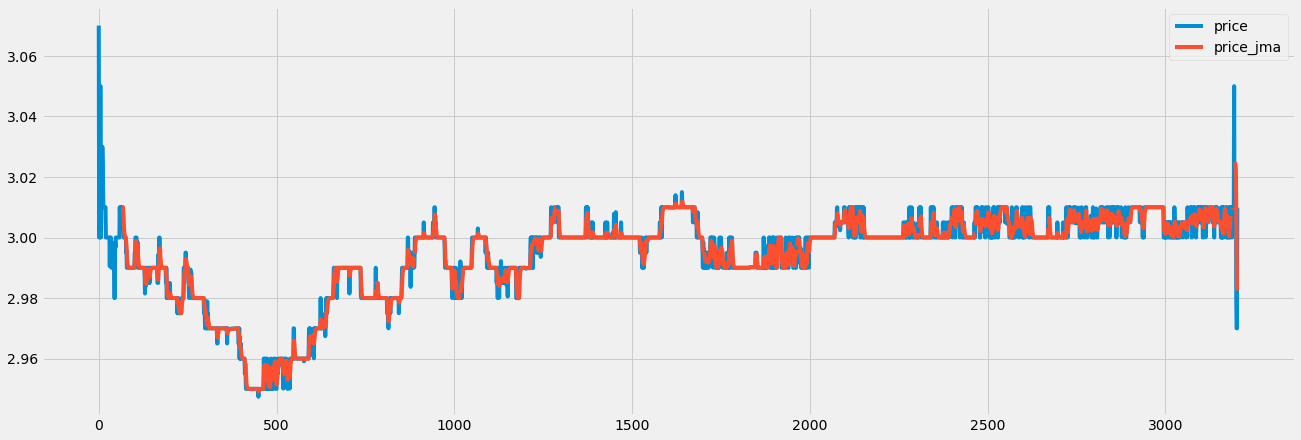

In [9]:
n = 0

bds[n]['ticks_df'][['price', 'price_jma']].plot()

<AxesSubplot:xlabel='nyc_dt'>

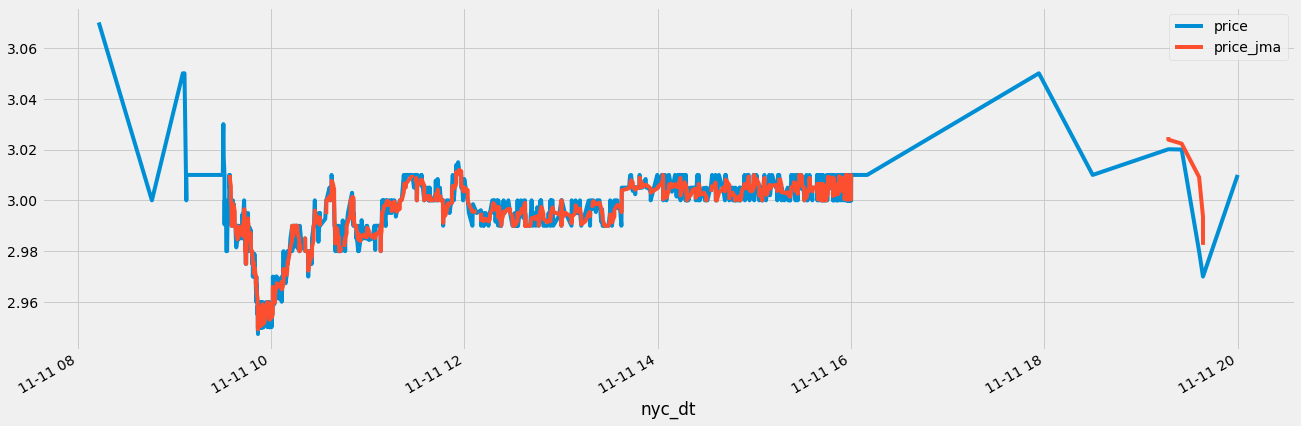

In [10]:
bds[n]['ticks_df'].set_index('nyc_dt')[['price', 'price_jma']].plot()

<AxesSubplot:xlabel='nyc_dt'>

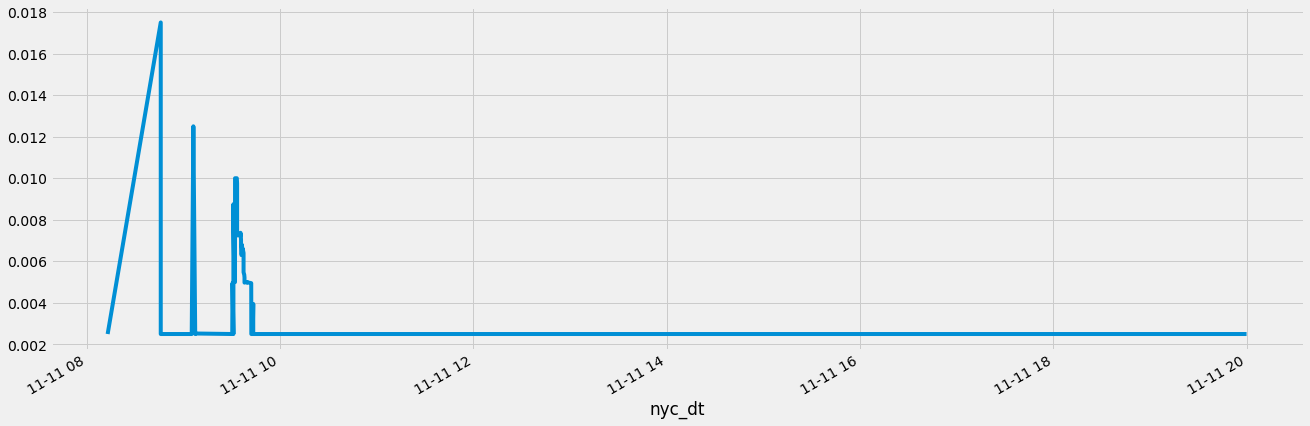

In [11]:
bds[n]['ticks_df'].set_index('nyc_dt')['mad'].plot()

<AxesSubplot:>

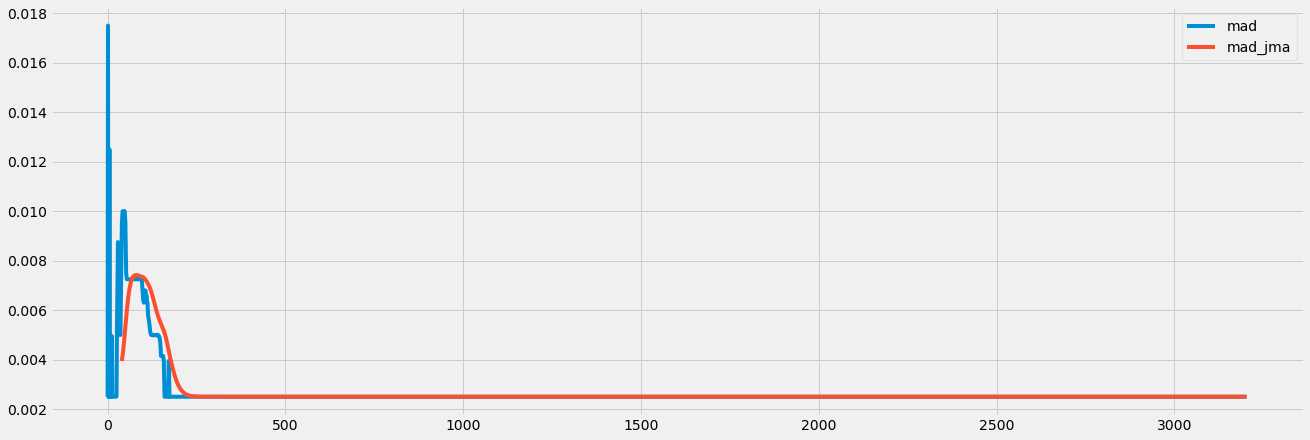

In [12]:
from filters.jma import jma_filter_df

jma_filter_df(bds[n]['ticks_df'], 'mad', winlen=int(len(bds[n]['ticks_df'])/77), power=1)[['mad', 'mad_jma']].plot()

In [13]:
pd.DataFrame(abs(bds[n]['bars_df'].label_rrr)).value_counts() / len(bds[n]['bars_df'])

label_rrr
0.000000    0.518519
2.000000    0.148148
2.500000    0.148148
3.000000    0.074074
4.500000    0.037037
5.000000    0.037037
5.500000    0.037037
dtype: float64

<AxesSubplot:>

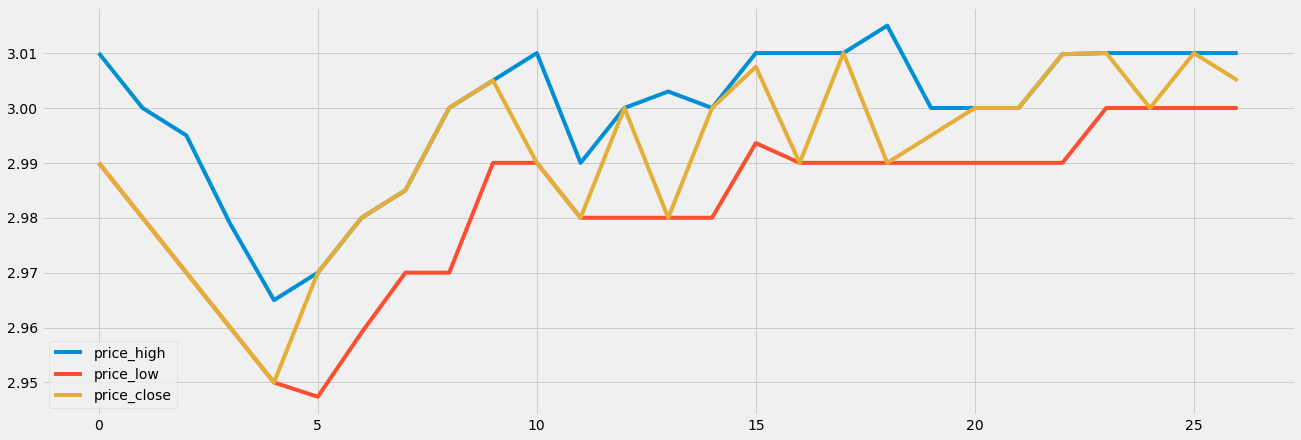

In [14]:
bds[n]['bars_df'][['price_high', 'price_low', 'price_close']].plot()

In [15]:
from utilities import pickle

bds = pickle.pickle_load('tmp/bds.pickle')

# pickle.pickle_dump(bds, 'tmp/bds.pickle')

In [57]:
# fill daily gaps
stacked_df = stacked.fill_gaps_dates(bds, fill_col='price_vwap')

stacked_df[['price_high','price_low','price_close', 'price_vwap']].plot_bokeh(sizing_mode="scale_height")

# stacked_df[['price_high','price_low','price_vwap']].plot()

Figure(id='1002', ...)

In [14]:
# stacked stats
stats_df = stacked.stacked_df_stats(stacked_df)

stats_df

stats_df.describe()

,bar_count,duration_min_median,price_range_mean
count,4.000000,4.000000,4.000000
mean,39.250000,6.527083,0.016677
std,13.225606,3.050845,0.001347
min,27.000000,2.358333,0.015349
25%,33.000000,5.227083,0.015691
50%,36.000000,7.308333,0.016543
75%,42.250000,8.608333,0.017530
max,58.000000,9.133333,0.018274
